In [1]:
# pip install --upgrade tensorflow

In [2]:
import os
import io
import json
import tensorflow as tf
from PIL import Image
import numpy as np
from datasets import load_dataset

2025-04-30 02:44:14.514424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745981054.692671      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745981054.743651      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepare Dataset

In [3]:
train_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
test_dataset = load_dataset("naver-clova-ix/cord-v2", split="test")
val_dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [4]:
label_map = {'item_name': 0, 'quantity': 1, 'price': 2}

In [5]:
import os
import json
import numpy as np
from tqdm import tqdm
from PIL import Image

save_dir = "cord_images"
train_save_dir = os.path.join(save_dir, "train")
val_save_dir = os.path.join(save_dir, "val")
os.makedirs(train_save_dir, exist_ok=True)
os.makedirs(val_save_dir, exist_ok=True)

def save_data(dataset, split):
    split_dir = os.path.join(save_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    new_dataset = []

    for i, example in tqdm(enumerate(dataset), total=len(dataset), desc=f"Saving {split} data"):
        tokens = []
        labels = []

        parsed = json.loads(example['ground_truth'])  # string -> dict
        gt_parse = parsed.get('gt_parse', {})

        image = example['image']  # dari huggingface, sudah PIL Image
        image_path = os.path.join(split_dir, f"{split}_{i:06d}.jpg")
        image.save(image_path, format="JPEG")

        for item in gt_parse.get('menu', []):
            if not isinstance(item, dict):
                continue

            item_name = item.get('nm', '')
            if isinstance(item_name, list):
                item_name = item_name[1] if item_name else ''
            item_name = str(item_name).strip().lower()

            quantity = str(item.get('cnt', '')).strip().lower()
            price = str(item.get('price', '')).strip().lower()

            for line in parsed.get('valid_line', []):
                words = line.get('words', [])
                line_text = ' '.join([w.get('text', '') for w in words]).strip().lower()

                if line_text == item_name:
                    for word in words:
                        if 'quad' in word:
                            quads = [word['quad'] for word in words if 'quad' in word]
                            if quads:
                                all_x = [q[f'x{i}'] for q in quads for i in range(1, 5)]
                                all_y = [q[f'y{i}'] for q in quads for i in range(1, 5)]
                                merged_quad = {
                                    'x1': min(all_x), 'y1': min(all_y),
                                    'x2': max(all_x), 'y2': min(all_y),
                                    'x3': max(all_x), 'y3': max(all_y),
                                    'x4': min(all_x), 'y4': max(all_y),
                                }
                            tokens.append(merged_quad)
                            labels.append(label_map['item_name'])

                elif line_text == quantity:
                    for word in words:
                        if 'quad' in word:
                            quads = [word['quad'] for word in words if 'quad' in word]
                            if quads:
                                all_x = [q[f'x{i}'] for q in quads for i in range(1, 5)]
                                all_y = [q[f'y{i}'] for q in quads for i in range(1, 5)]
                                merged_quad = {
                                    'x1': min(all_x), 'y1': min(all_y),
                                    'x2': max(all_x), 'y2': min(all_y),
                                    'x3': max(all_x), 'y3': max(all_y),
                                    'x4': min(all_x), 'y4': max(all_y),
                                }
                            tokens.append(merged_quad)
                            labels.append(label_map['quantity'])

                elif line_text == price:
                    for word in words:
                        if 'quad' in word:
                            quads = [word['quad'] for word in words if 'quad' in word]
                            if quads:
                                all_x = [q[f'x{i}'] for q in quads for i in range(1, 5)]
                                all_y = [q[f'y{i}'] for q in quads for i in range(1, 5)]
                                merged_quad = {
                                    'x1': min(all_x), 'y1': min(all_y),
                                    'x2': max(all_x), 'y2': min(all_y),
                                    'x3': max(all_x), 'y3': max(all_y),
                                    'x4': min(all_x), 'y4': max(all_y),
                                }
                            tokens.append(merged_quad)
                            labels.append(label_map['price'])

        new_dataset.append({
            "image_path": image_path,
            "boxes": tokens,
            "labels": labels
        })

    # for d in new_dataset:
    #     if d['boxes']:
    #         print("Image:", d['image_path'])
    #         print("Boxes:", d['boxes'])
    #         print("Labels:", d['labels'])
    #         print()
    #         break  # Print 1 contoh saja

    return new_dataset

In [6]:
from datasets import concatenate_datasets

new_train_dataset = save_data(concatenate_datasets([train_dataset, test_dataset]), "train")
new_val_dataset = save_data(val_dataset, "val")

Saving val data: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image_path, boxes, labels, label_map_reverse):
    """
    - image_path: path gambar
    - boxes: list of dict {x1, y1, ..., x4, y4}
    - labels: list of label int
    - label_map_reverse: dict dari int -> string label
    """
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for box, label in zip(boxes, labels):
        # Cari min-max koordinat buat kotak axis-aligned
        xs = [box['x1'], box['x2'], box['x3'], box['x4']]
        ys = [box['y1'], box['y2'], box['y3'], box['y4']]
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        
        width = xmax - xmin
        height = ymax - ymin
        
        # Tambahkan kotak
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Tulis label
        label_text = label_map_reverse[label]
        ax.text(xmin, ymin - 5, label_text, color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

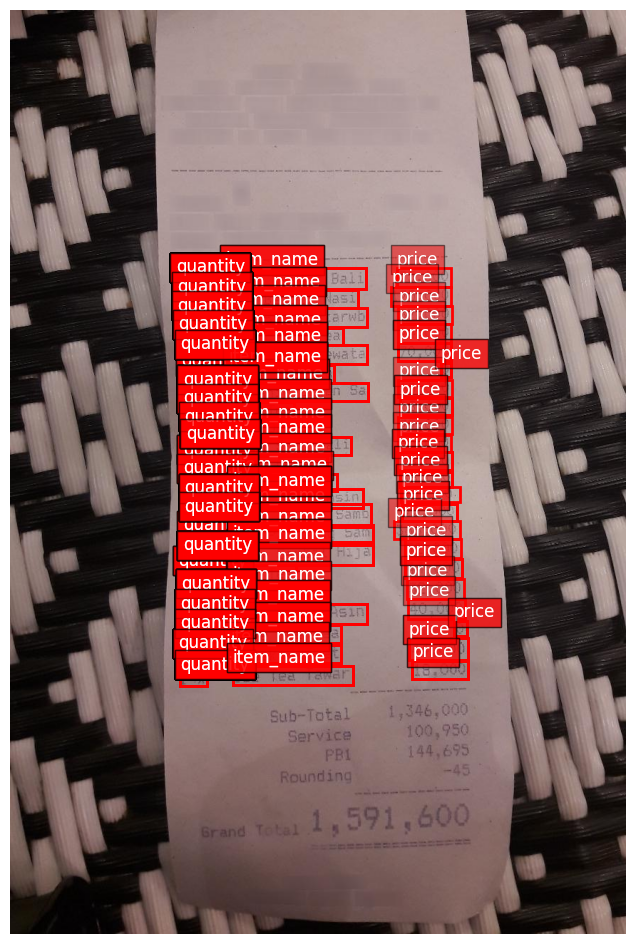

In [8]:
# Misal mapping label kamu:
label_map_reverse = {v: k for k, v in label_map.items()}

# Pilih 1 data buat dicek:
sample = new_train_dataset[0]
# print(sample['labels'])
plot_image_with_boxes(
    image_path=sample['image_path'],
    boxes=sample['boxes'],
    labels=sample['labels'],
    label_map_reverse=label_map_reverse
)

# BUILD MODEL

In [9]:
#hyperparam
BATCH_SIZE = 4
STEPS_PER_EPOCH = len(new_train_dataset)//BATCH_SIZE
EPOCH = 5
INITIAL_LR = 1e-5
MOMENTUM = 0.9
GRADIENT_CLIP_NORM = 1.0
STD_DEV = 0.01

In [10]:
from keras.applications import EfficientNetB0
from keras import layers, Model, regularizers
from keras.layers import Input, Conv2D, Concatenate, UpSampling2D, Dropout

num_classes = len(label_map)
l2_reg = regularizers.l2(1e-4)  # L2 regularization

# Backbone
input_tensor = Input(shape=(640, 640, 3), name="image")
pre_trained_model = EfficientNetB0(
    input_tensor=input_tensor,
    include_top=False,
    weights='imagenet'
)

# Feature maps dari EfficientNet
c3_output = pre_trained_model.get_layer("block3a_expand_activation").output  # 80x80
c4_output = pre_trained_model.get_layer("block4a_expand_activation").output  # 40x40
c5_output = pre_trained_model.get_layer("block6a_expand_activation").output  # 20x20

# FPN
p5 = Conv2D(64, 1, padding='same', activation='relu', kernel_regularizer=l2_reg)(c5_output)
p5_upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(p5)

p4 = Conv2D(64, 1, padding='same', activation='relu', kernel_regularizer=l2_reg)(c4_output)
p4 = Concatenate()([p5_upsampled, p4])
p4 = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(p4)
p4_upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(p4)

p3 = Conv2D(64, 1, padding='same', activation='relu', kernel_regularizer=l2_reg)(c3_output)
p3 = Concatenate()([p4_upsampled, p3])
p3 = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(p3)

# Heatmap Head
heatmap_head = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(p3)
heatmap_head = Dropout(0.2)(heatmap_head)
heatmap_output = Conv2D(num_classes, 1, padding='same', activation='sigmoid', name='class_output')(heatmap_head)

# Regression Head
reg_head = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(p3)
reg_head = Dropout(0.2)(reg_head)
reg_output = Conv2D(4, 1, padding='same', name='bbox_output')(reg_head)

# Offset Head
offset_head = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(p3)
offset_head = Dropout(0.2)(offset_head)
offset_output = Conv2D(2, 1, padding='same', name='offset_output')(offset_head)

# Final model
model = Model(inputs=pre_trained_model.input,
              outputs=[reg_output, heatmap_output, offset_output])
model.summary()

I0000 00:00:1745981153.985846      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 640, 640, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 640, 640, 3)    │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 640, 640, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 640, 640, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 641, 641, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 320, 320, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 320, 320, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 320, 320, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 320, 320, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 320, 320, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 320, 320, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 1,272,656 (4.85 MB)

 Trainable params: 1,255,145 (4.79 MB)

 Non-trainable params: 17,511 (68.41 KB)

In [11]:
import tensorflow as tf
import random

def augment_image(image):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return tf.clip_by_value(image, 0.0, 1.0)

def data_generator(dataset, label_map, image_size=(640, 640), batch_size=8, augment=True, down_ratio=4):
    def gen():
        idx = 0
        output_size = image_size[0] // down_ratio  # diasumsikan square image
        while True:
            batch_data = dataset[idx * batch_size:(idx + 1) * batch_size]
            if not batch_data:
                idx = 0
                continue

            images, heatmaps, regs, offsets = [], [], [], []

            for example in batch_data:
                image = tf.io.read_file(example['image_path'])
                image = tf.image.decode_jpeg(image, channels=3)
                image = tf.image.resize(image, image_size) / 255.0

                if augment:
                    image = augment_image(image)

                heatmap = tf.zeros((output_size, output_size, len(label_map)), dtype=tf.float32)
                reg = tf.zeros((output_size, output_size, 4), dtype=tf.float32)
                offset = tf.zeros((output_size, output_size, 2), dtype=tf.float32)

                for box, label in zip(example['boxes'], example['labels']):
                    x_coords = [box['x1'], box['x2'], box['x3'], box['x4']]
                    y_coords = [box['y1'], box['y2'], box['y3'], box['y4']]

                    x_min = min(x_coords)
                    y_min = min(y_coords)
                    x_max = max(x_coords)
                    y_max = max(y_coords)

                    cx = (x_min + x_max) / 2 / image_size[0]
                    cy = (y_min + y_max) / 2 / image_size[1]
                    w = (x_max - x_min) / image_size[0]
                    h = (y_max - y_min) / image_size[1]

                    grid_x = int(cx * output_size)
                    grid_y = int(cy * output_size)

                    if 0 <= grid_x < output_size and 0 <= grid_y < output_size:
                        cx_offset = cx * output_size - grid_x
                        cy_offset = cy * output_size - grid_y

                        # Heatmap (label)
                        heatmap = tf.tensor_scatter_nd_update(
                            heatmap,
                            [[grid_y, grid_x, label]],
                            [1.0]
                        )

                        # Regression (cx_offset, cy_offset, w, h)
                        reg = tf.tensor_scatter_nd_update(
                            reg,
                            [[grid_y, grid_x, i] for i in range(4)],
                            [cx_offset, cy_offset, w, h]
                        )

                        # Offset (cx relative position in grid)
                        offset = tf.tensor_scatter_nd_update(
                            offset,
                            [[grid_y, grid_x, 0], [grid_y, grid_x, 1]],
                            [cx_offset, cy_offset]
                        )

                images.append(image)
                heatmaps.append(heatmap)
                regs.append(reg)
                offsets.append(offset)

            idx += 1
            yield (
                tf.stack(images),
                {
                    "bbox_output": tf.stack(regs),
                    "class_output": tf.stack(heatmaps),
                    "offset_output": tf.stack(offsets)
                }
            )
    return gen

In [12]:
import tensorflow as tf
import numpy as np

class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor_acc="val_class_output_accuracy", monitor_mae="val_bbox_output_mae", verbose=1, save_best_only=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.filepath = filepath
        self.monitor_acc = monitor_acc
        self.monitor_mae = monitor_mae
        self.verbose = verbose
        self.best_score = -np.inf  # Semakin tinggi semakin baik
        self.save_best_only = save_best_only

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        val_acc = logs.get(self.monitor_acc)
        val_mae = logs.get(self.monitor_mae)

        if val_acc is None or val_mae is None:
            if self.verbose:
                print(f"Warning: Metric {self.monitor_acc} or {self.monitor_mae} not available in logs.")
            return

        # Skor kombinasi: akurasi tinggi dan MAE rendah
        score = val_acc - val_mae

        if self.save_best_only:
            if score > self.best_score:
                if self.verbose:
                    print(f"\nEpoch {epoch+1}: Improved score from {self.best_score:.5f} to {score:.5f}, saving model to {self.filepath}")
                self.best_score = score
                self.model.save(self.filepath)
            else:
                if self.verbose:
                    print(f"\nEpoch {epoch+1}: No improvement in score ({score:.5f} <= {self.best_score:.5f})")
        else:
            if self.verbose:
                print(f"\nEpoch {epoch+1}: Saving model to {self.filepath} (not using save_best_only)")
            self.model.save(self.filepath)


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_bbox_output_mae",  # Bisa juga val_loss jika mau umum
    factor=0.5,           # Turunkan learning rate ke 50%
    patience=3,           # Setelah 3 epoch tanpa perbaikan
    verbose=1,
    min_lr=INITIAL_LR          # Minimal learning rate
)

# Custom checkpoint callback
checkpoint_cb = CustomModelCheckpoint(
    save_best_only=True,
    filepath="best_retinanet.keras",
    monitor_mae="val_bbox_output_mae",
    monitor_acc="val_class_output_accuracy",
    verbose=1
)

# Early stopping tetap biasa
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# TensorBoard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir="./logs",
    update_freq="epoch"
)

In [14]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=INITIAL_LR,
    beta_1=MOMENTUM,
    clipnorm=GRADIENT_CLIP_NORM
)

In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=-1)
    return loss


In [16]:
model.compile(
    optimizer=optimizer,
    loss={
        'bbox_output': 'mse',
        'class_output': 'categorical_crossentropy',  # or 'binary_crossentropy'
        'offset_output': 'mse'
    },
    metrics={
        'bbox_output': 'mae',
        'class_output': 'accuracy',
        'offset_output': 'mae'
    },
    loss_weights={
        "bbox_output": 1.0,
        "class_output": 10.0,   # berikan bobot besar karena loss-nya kecil
        "offset_output": 1.0
    }
)

In [17]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/kaggle/working/training_log.csv', separator=',', append=True)

In [18]:
from collections import Counter

all_labels = []
for sample in new_train_dataset:  # dataset ground truth
    for label in sample['labels']:
        all_labels.append(label)

label_distribution = Counter(all_labels)
print("Ground truth class distribution:", label_distribution)

def to_tuple(box):
    return tuple(box)  # atau (label, x1, y1, x2, y2)

all_boxes = [to_tuple(b) for sample in new_train_dataset for b in sample['boxes']]
duplicates = Counter(all_boxes)

dupes = {box: count for box, count in duplicates.items() if count > 1}
print("Duplicate bounding boxes:", dupes)


Ground truth class distribution: Counter({1: 7520, 0: 5406, 2: 2963})
Duplicate bounding boxes: {('x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'): 15889}


In [19]:
train_gen = data_generator(new_train_dataset, label_map, batch_size=BATCH_SIZE)
train_ds = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32),
        {
            "bbox_output": tf.TensorSpec(shape=(None, 160, 160, 4), dtype=tf.float32),
            "class_output": tf.TensorSpec(shape=(None, 160, 160, len(label_map)), dtype=tf.float32),
            "offset_output": tf.TensorSpec(shape=(None, 160, 160, 2), dtype=tf.float32)
        }
    )
).repeat().shuffle(500).prefetch(tf.data.AUTOTUNE)

val_gen = data_generator(new_val_dataset, label_map, batch_size=BATCH_SIZE)
val_ds = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32),
        {
            "bbox_output": tf.TensorSpec(shape=(None, 160, 160, 4), dtype=tf.float32),
            "class_output": tf.TensorSpec(shape=(None, 160, 160, len(label_map)), dtype=tf.float32),
            "offset_output": tf.TensorSpec(shape=(None, 160, 160, 2), dtype=tf.float32)
        }
    )
).prefetch(tf.data.AUTOTUNE)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    validation_steps=500,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCH,
    callbacks=[csv_logger, checkpoint_cb, reduce_lr, tensorboard_cb, earlystop_cb]
)

Epoch 1/5


E0000 00:00:1745981302.974279     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745981303.168251     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745981303.600643     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745981303.815043     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745981304.032237     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - bbox_output_loss: 0.2657 - bbox_output_mae: 0.3883 - class_output_accuracy: 0.2672 - class_output_loss: 0.0014 - loss: 0.6550 - offset_output_loss: 0.3211 - offset_output_mae: 0.4306
Epoch 1: Improved score from -inf to -0.10154, saving model to best_retinanet.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 295s 560ms/step - bbox_output_loss: 0.2656 - bbox_output_mae: 0.3882 - class_output_accuracy: 0.2675 - class_output_loss: 0.0014 - loss: 0.6549 - offset_output_loss: 0.3211 - offset_output_mae: 0.4306 - val_bbox_output_loss: 0.0179 - val_bbox_output_mae: 0.1080 - val_class_output_accuracy: 0.0064 - val_class_output_loss: 0.0010 - val_loss: 0.0954 - val_offset_output_loss: 0.0096 - val_offset_output_mae: 0.0607 - learning_rate: 1.0000e-05
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - bbox_output_loss: 0.1079 - bbox_output_mae: 0.2149 - class_output_accuracy: 0.3297 - class_output_loss: 0.0026 - loss: 0.4837 - offset_output_loss: 0.3062 - offse

In [22]:
# # Load model yang sudah ada (misalnya dari checkpoint atau file model yang disimpan)
# model = tf.keras.models.load_model('/kaggle/working/best_retinanet.keras')

# # Kemudian lanjutkan training
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     validation_steps=500,
#     initial_epoch=4,  # Lanjutkan dari epoch 5
#     steps_per_epoch=STEPS_PER_EPOCH,
#     epochs=EPOCH,
#     callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, log_first_batch_cb]
# )


# Analisis dan Simpan Model

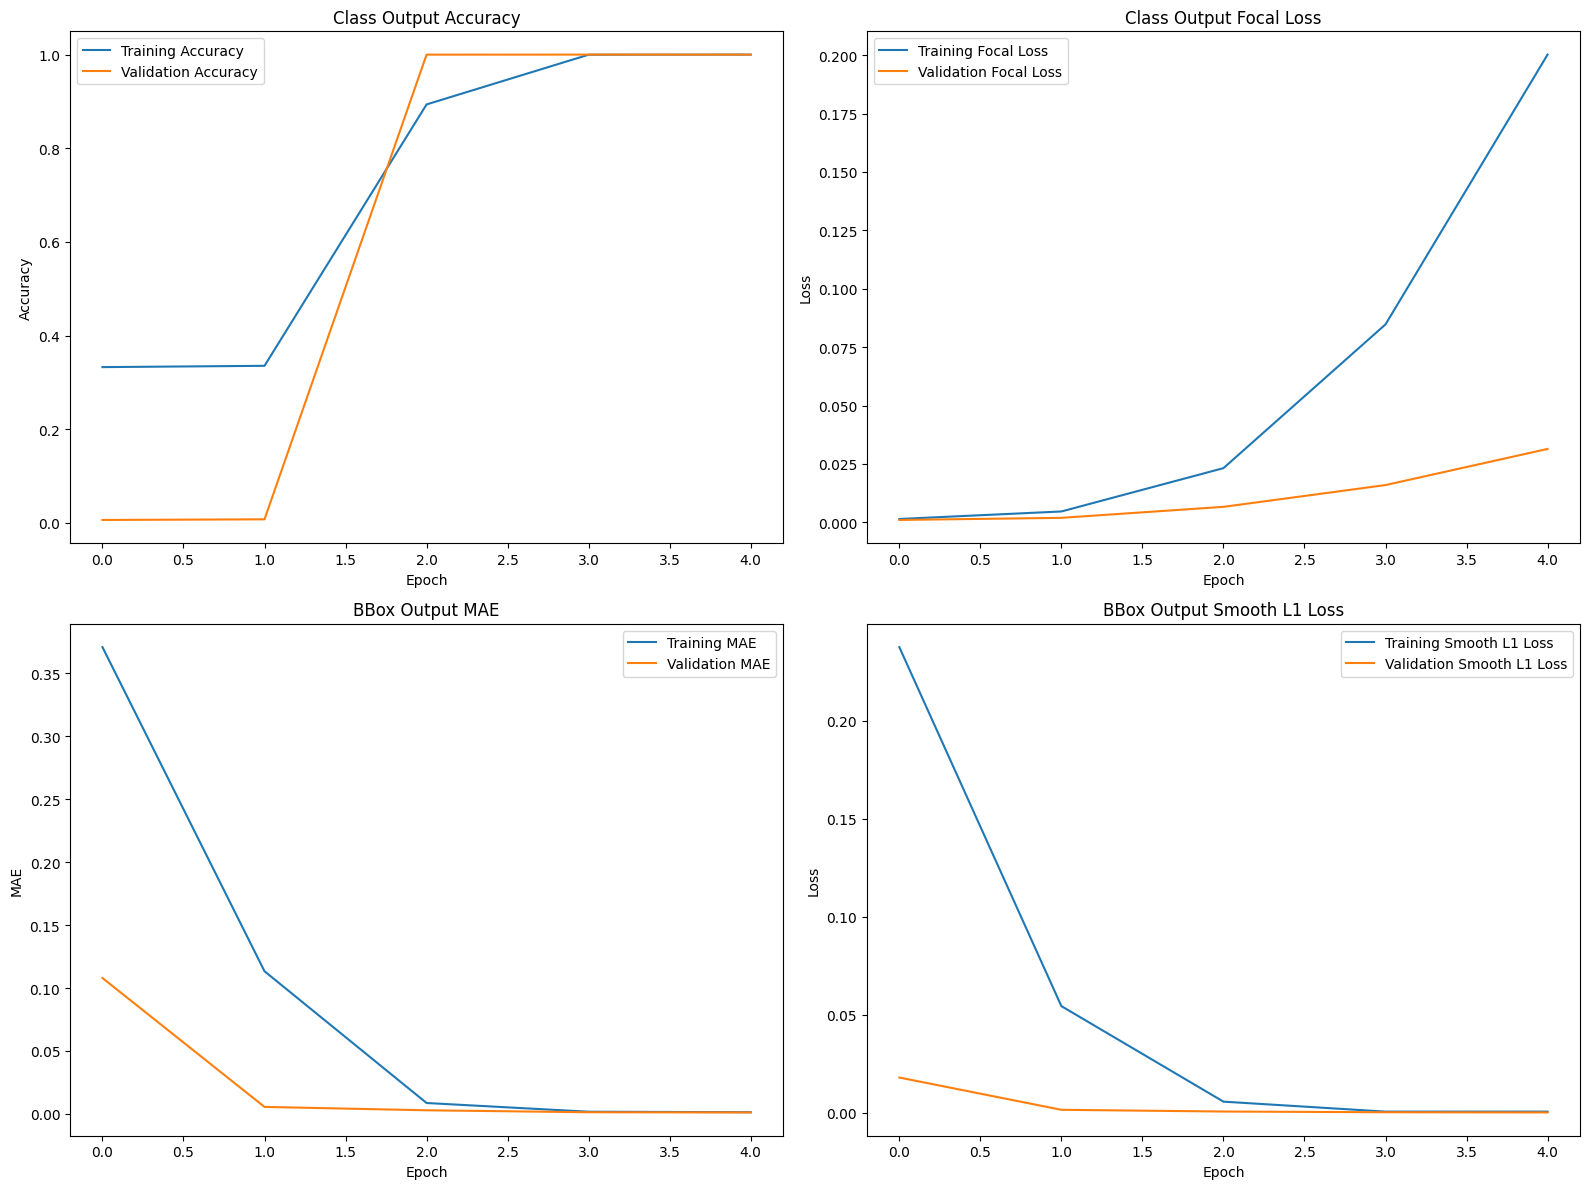

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

log_data = pd.read_csv('/kaggle/working/training_log.csv')

plt.figure(figsize=(16, 12))

# Plot untuk accuracy class_output
plt.subplot(2, 2, 1)
plt.title('Class Output Accuracy')
plt.plot(log_data['epoch'], log_data['class_output_accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot untuk Focal Loss class_output
plt.subplot(2, 2, 2)
plt.title('Class Output Focal Loss')
plt.plot(log_data['epoch'], log_data['class_output_loss'], label='Training Focal Loss')  # Ganti dengan Focal Loss
plt.plot(log_data['epoch'], log_data['val_class_output_loss'], label='Validation Focal Loss')  # Ganti dengan Focal Loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot untuk MAE bbox_output
plt.subplot(2, 2, 3)
plt.title('BBox Output MAE')
plt.plot(log_data['epoch'], log_data['bbox_output_mae'], label='Training MAE')
plt.plot(log_data['epoch'], log_data['val_bbox_output_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot untuk Smooth L1 Loss bbox_output
plt.subplot(2, 2, 4)
plt.title('BBox Output Smooth L1 Loss')
plt.plot(log_data['epoch'], log_data['bbox_output_loss'], label='Training Smooth L1 Loss')  # Ganti dengan Smooth L1 Loss
plt.plot(log_data['epoch'], log_data['val_bbox_output_loss'], label='Validation Smooth L1 Loss')  # Ganti dengan Smooth L1 Loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
model.save("bbox_model.h5")
model.save("bbox_model.keras")
print("Model saved successfully!")

Model saved successfully!


In [25]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os

In [26]:
drive_service = build('drive', 'v3')

folder_id = "1a0i_DpxSo1RnkT7ZjUr_AdawVvW2vBSX"  # Dapatkan dari URL Google Drive folder kamu

# # # Zip folder SavedModel
# # shutil.make_archive("final_faster_rcnn_resnet50v2", 'zip', "final_faster_rcnn_resnet50v2")

# # file_metadata = {
# #     "name": "final_faster_rcnn_resnet50v2",
# #     "parents": [folder_id]
# # }
# # media_savedmodel = MediaFileUpload("final_faster_rcnn_resnet50v2", mimetype="application/octet-stream")
# # file_savedmodel = drive_service.files().create(body=file_metadata_savedmodel, media_body=media_savedmodel, fields="id").execute()
# # print(f"File uploaded with ID: {file_savedmodel.get('id')}")

file_metadata = {
    "name": "bbox_model.keras",
    "parents": [folder_id]
}
media = MediaFileUpload("bbox_model.keras", mimetype="application/octet-stream")

file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
print(f"File uploaded with ID: {file.get('id')}")

file_metadata_h5 = {
    "name": "bbox_model.h5",
    "parents": [folder_id]
}
media_h5 = MediaFileUpload("bbox_model.h5", mimetype="application/octet-stream")

file_h5 = drive_service.files().create(body=file_metadata_h5, media_body=media_h5, fields="id").execute()
print(f"File uploaded with ID: {file_h5.get('id')}")

File uploaded with ID: 19v_BW6Y8thEtubi_jVkixdnZVIS9egPQ
File uploaded with ID: 1LHbnma-ii68FZEFRSXBDoBSlq0D39fzo
